In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-minimum-temperatures-in-melbourne/daily-minimum-temperatures-in-me.csv
/kaggle/input/daily-temperatures-in-melboune-city/dataset.csv


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [54]:
data= pd.read_csv("/kaggle/input/daily-temperatures-in-melboune-city/dataset.csv", parse_dates=['Date'])

In [55]:
data.head()

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,01-01-1981,20.7
1,02-01-1981,17.9
2,03-01-1981,18.8
3,04-01-1981,14.6
4,05-01-1981,15.8


In [56]:
str(data)

'            Date Daily minimum temperatures in Melbourne, Australia, 1981-1990\n0     01-01-1981                                               20.7           \n1     02-01-1981                                               17.9           \n2     03-01-1981                                               18.8           \n3     04-01-1981                                               14.6           \n4     05-01-1981                                               15.8           \n...          ...                                                ...           \n3645  27-12-1990                                                 14           \n3646  28-12-1990                                               13.6           \n3647  29-12-1990                                               13.5           \n3648  30-12-1990                                               15.7           \n3649  31-12-1990                                                 13           \n\n[3650 rows x 2 columns]'

In [57]:
data.shape

(3650, 2)

Text(0, 0.5, 'temperatures')

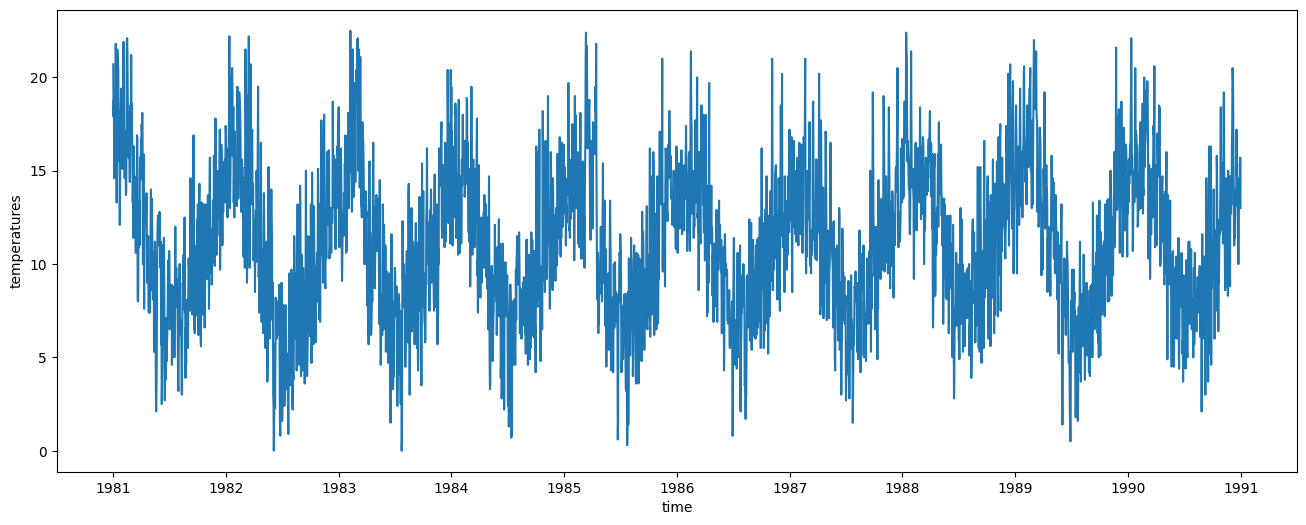

In [73]:
x=data.iloc[:, 0]
y=data.iloc[:, 1]

plt.figure(figsize=(16,6)) 
plt.plot(x,y)
plt.xlabel("time")
plt.ylabel("temperatures")

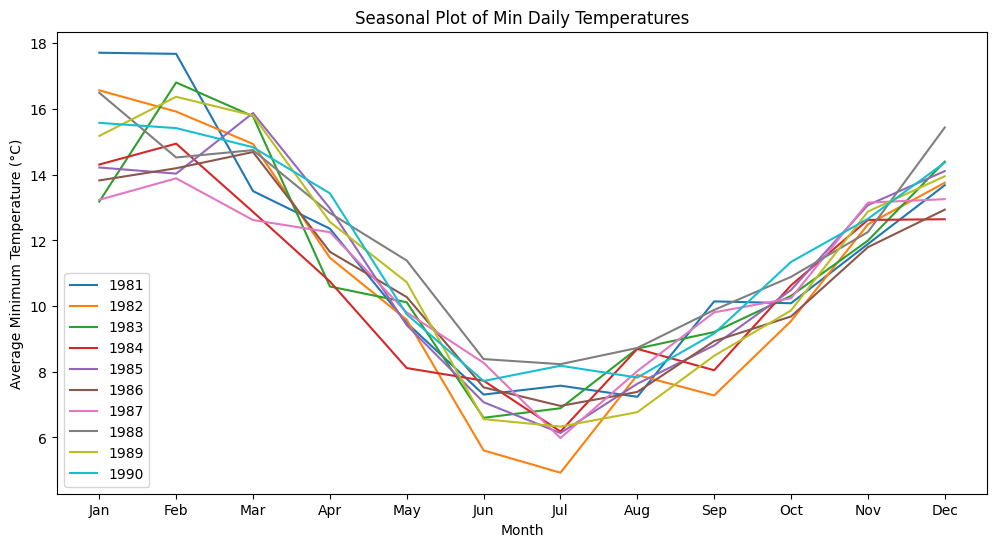

In [59]:

data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'Temp'}, inplace=True)
data['Temp'] = pd.to_numeric(data['Temp'], errors='coerce')


data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.strftime('%b')


monthly_avg = data.groupby(['Year', 'Month'])['Temp'].mean().reset_index()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg['Month'] = pd.Categorical(monthly_avg['Month'], categories=month_order, ordered=True)
pivot = monthly_avg.pivot(index='Month', columns='Year', values='Temp')

plt.figure(figsize=(12, 6))
for year in pivot.columns:
    plt.plot(pivot.index, pivot[year], label=str(year))
    
plt.title('Seasonal Plot of Min Daily Temperatures')
plt.xlabel('Month')
plt.ylabel('Average Minimum Temperature (°C)')
plt.legend()
plt.show()


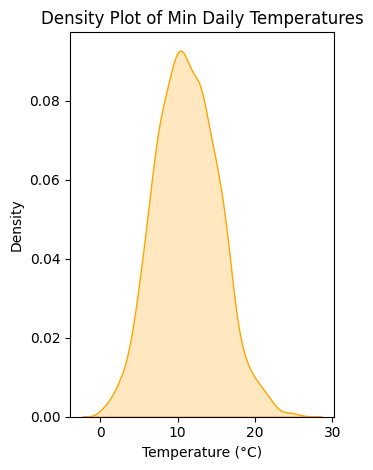

In [60]:
plt.hist(data['Temp'], bins=25, color='skyblue', edgecolor='black')
plt.title('Histogram of Min Daily Temperatures')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

# KDE / Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(data['Temp'], fill=True, color='orange')
plt.title('Density Plot of Min Daily Temperatures')
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [61]:
data.isnull().sum()

Date     0
Temp     3
Year     0
Month    0
dtype: int64

Text(0.5, 1.0, 'Boxplot of Temperature')

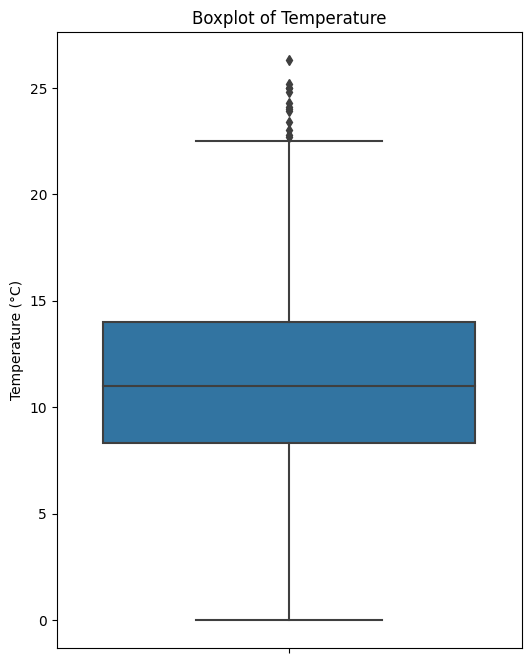

In [62]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=data['Temp'])
plt.ylabel('Temperature (°C)')
plt.title('Boxplot of Temperature')


In [63]:
#As our data contains some outliers, we need to remove them

Q1 = data['Temp'].quantile(0.25)
Q3 = data['Temp'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['Temp'] >= lower_bound) & (data['Temp'] <= upper_bound)]

print("outliers removed from dataset")

print("new data shape is: ", data.shape)


outliers removed from dataset
new data shape is:  (3634, 4)


In [64]:
data.shape

(3634, 4)

In [65]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data['Temp'].values.reshape(-1, 1))

X, y = [], []
for i in range(10, len(scaled)):
    X.append(scaled[i-10:i])
    y.append(scaled[i])
X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0692
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124
Epoch 9/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 10/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122
Epoch 11/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 12/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114
Epoch 13/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119
Epoch 14/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115
Epoch 15/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

In [66]:
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 0.08
MSE: 0.01
RMSE: 0.10
R²: 0.71


In [67]:
#There are other models also like the prophet model they can be compared using pycaret